In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln
from external.pyem.pyem import star
import pandas as pd


plt.rcParams["figure.figsize"]=6,6

In [3]:
# Dirs and file locations

out_dir = "../simulated_dataset5k/"


# Relion data
#refine3dfile = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/Refine3D/job019/run_class001.mrc"
#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

# Cryodrgn data
refine3dfile = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/run_class001.mrc"
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/"
star_file = "/run_it000_data.star"


In [5]:
# Read the volume and the parameters from the star file

vol_r = mrcfile.open(refine3dfile).data


params, _ = load_data(data_dir, star_file, load_imgs = False, fourier = False)

ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]
nx = vol_r.shape[0]

print(f"vol_r.shape = {vol_r.shape}")

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  105519
load_data: data loaded, time:  24.869733810424805
vol_r.shape = (320, 320, 320)


In [6]:
# Take FFT of volume

vol_f, grid, _ = volume_fourier(vol_r, pixel_size[0])

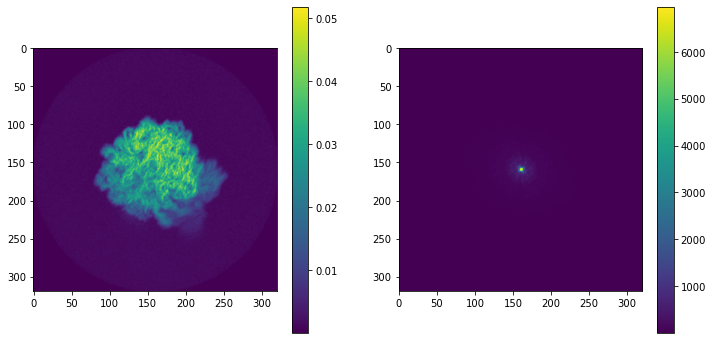

In [7]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
mip_z(vol_r); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.abs(np.fft.fftshift(vol_f))); plt.colorbar()

In [40]:
out_dir = "../simulated_dataset10k/"


In [10]:
# Save the vol

with mrcfile.new(f"{out_dir}/vol2_{nx}.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_r.astype(np.float32))

#### Look at the downsampled volume 

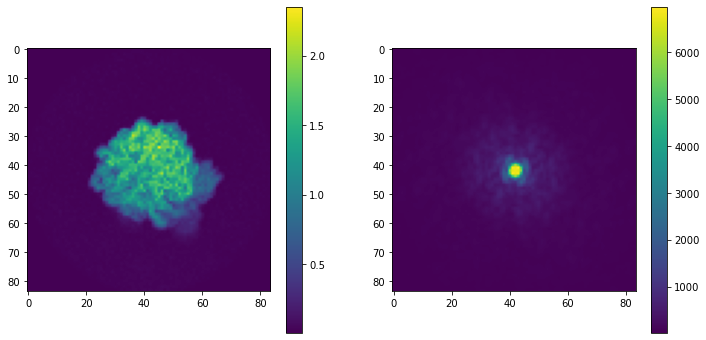

In [18]:
# First, crop to 64px

nx1 = 84

vol_fc, grid_c = crop_fourier_volume(vol_f, grid, nx1)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))

plt.subplot(1,2,1)
mip_z(vol_rc); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.abs(np.fft.fftshift(vol_fc))); plt.colorbar()

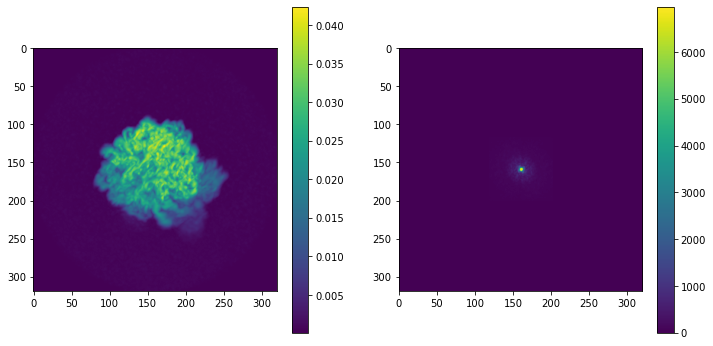

In [19]:
# Obtain the nx0 size volume

vol_fc, _ = rescale_larger_grid(vol_fc, grid_c, nx)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))

plt.subplot(1,2,1)
mip_z(vol_rc); plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.abs(np.fft.fftshift(vol_fc))); plt.colorbar()

In [22]:
with mrcfile.new(f"{out_dir}/vol2_{nx1}.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_rc.astype(np.float32))

### Project

In [27]:
mask = np.ones(vol_f.shape)
slice_func, slice_func_array, _ = get_slice_funcs(project, grid, mask)

def prepare_imgs(imgs_f, angles, shifts, ctf_params, sigma_noise):
    # IFFT
    imgs = np.array([np.real(np.fft.fftshift(np.fft.ifft2(img_f.reshape([nx,nx])))) for img_f in imgs_f])
        
    # Add noise 
    if sigma_noise > 0:
        sigma_noise = sigma_noise * np.max(np.abs(imgs))
        imgs_noisy = imgs + sigma_noise * np.random.randn(N, nx, nx) 
        
    # FFT of noisy images too 
    imgs_noisy_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs_noisy])
   
    return imgs, imgs_f, imgs_noisy, imgs_noisy_f
    
def write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs, nx, pixel_size):
                    
    # And write to mrcs file
    with mrcfile.new(f"{out_dir}/{mrcs_dir}/{imgs_filename}.mrcs", overwrite=True) as mrc:
        mrc.set_data(imgs.astype(np.float32))
    
    # Create star file

    # See, for example, this one:
    df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
    #df
    #df.keys()

    newdf = pd.DataFrame()
    newdf["index"] = np.arange(N)

    newdf[star.Relion.ANGLEPSI] = np.rad2deg(angles[:,0])
    newdf[star.Relion.ANGLETILT] = np.rad2deg(angles[:,1])
    newdf[star.Relion.ANGLEROT] = np.rad2deg(angles[:,2])

    newdf[star.Relion.ORIGINX] = 0
    newdf[star.Relion.ORIGINY] = 0
    newdf[star.Relion.ORIGINXANGST] = 0
    newdf[star.Relion.ORIGINYANGST] = 0

    newdf[star.Relion.DEFOCUSU] = ctf_params[:,0] 
    newdf[star.Relion.DEFOCUSV] = ctf_params[:,1]
    newdf[star.Relion.DEFOCUSANGLE] = ctf_params[:,2]
    newdf[star.Relion.PHASESHIFT] = ctf_params[:,3]
    newdf[star.Relion.VOLTAGE] = ctf_params[:,4]
    newdf[star.Relion.AC] = ctf_params[:,5]
    newdf[star.Relion.CS] = ctf_params[:,6]

    newdf[star.Relion.IMAGESIZE] = nx
    newdf[star.Relion.IMAGEPIXELSIZE] = pixel_size 

    newdf[star.Relion.VOLTAGE] = df[star.Relion.VOLTAGE][0] 
    newdf[star.Relion.OPTICSGROUP] = 1
    newdf[star.Relion.OPTICSGROUPNAME] = df[star.Relion.OPTICSGROUPNAME][0]
    newdf[star.Relion.CTFSCALEFACTOR] = df[star.Relion.CTFSCALEFACTOR][0]

    newdf[star.UCSF.IMAGE_ORIGINAL_PATH] = f"{imgs_filename}.mrcs"
    newdf[star.Relion.IMAGE_NAME] = [f"{i}@{imgs_filename}.mrcs" for i in np.arange(N)]
    #newdf
    
    star.write_star(f"{out_dir}/{mrcs_dir}/{imgs_filename}", newdf)
    
    return newdf


def compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy):
    norm_imgs = np.mean(np.real(np.sum(np.conj(imgs)*imgs, axis=(1,2))))
    norm_imgs_noisy = np.mean(np.real(np.sum(np.conj(imgs_noisy)*imgs_noisy, axis=(1,2))))

    norm_imgs_f = np.mean(np.real(np.sum(np.conj(imgs_f)*imgs_f, axis = 1)))
    norm_imgs_f_noisy = np.mean(np.real(np.sum(np.conj(imgs_f_noisy)*imgs_f_noisy, axis=(1,2))))

    #print(time.time()-start)

    #SNR
    snr = norm_imgs/norm_imgs_noisy
    snr_f = norm_imgs_f/norm_imgs_f_noisy
    print(f"SNR = {snr}")
    print(f"SNR_F = {snr_f}")

    return snr, snr_f


### 1. Project, save to file etc

In [28]:
#mrcs_dir_clean = "relion_clean"
#mrcs_dir_noisy = "relion_noisy"

mrcs_dir_clean = "cryodrgn_clean"
mrcs_dir_noisy = "cryodrgn_noisy"

imgs_filename = "particles"

In [41]:
N = 10000
sigma_noise = 0.35
shifts = np.zeros([N,2])
ctf_params = np.tile(ctf_params[0], (N,1))
angles = generate_uniform_orientations(N)

In [42]:
# Take projections in Fourier - in batches so they fit on the GPU
N_batch = 10
angles_batch = np.array(np.array_split(angles, N_batch))
shifts_batch = np.array(np.array_split(shifts, N_batch))
ctf_params_batch = np.array(np.array_split(ctf_params, N_batch))

imgs_f_batch = [] 


for bi in np.arange(N_batch):
    imgs_f = slice_func_array(vol_f, angles_batch[bi], shifts_batch[bi], ctf_params_batch[bi])
    
    # Move to CPU
    imgs_f_batch.append(np.array(imgs_f))
    
imgs_f = np.concatenate(imgs_f_batch, axis=0)

In [43]:
imgs_f_batch[0].shape

(1000, 102400)

In [44]:
imgs_f.shape

(10000, 102400)

In [45]:
imgs, imgs_f, imgs_noisy, imgs_f_noisy = prepare_imgs(imgs_f, angles, shifts, ctf_params, sigma_noise)

In [46]:
_, _ = compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy)

SNR = 0.02628578330997166
SNR_F = 0.026285783450548512


In [47]:
pixel_size[0]

1.31

In [48]:
df_clean = write_star_and_mrcs(out_dir, mrcs_dir_clean, imgs_filename, imgs, nx, pixel_size[0])
df_noisy = write_star_and_mrcs(out_dir, mrcs_dir_noisy, imgs_filename, imgs_noisy, nx, pixel_size[0])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [49]:
#df

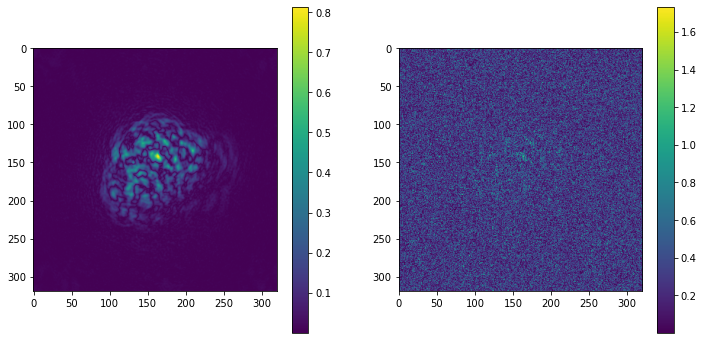

In [50]:
idx = 14
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow((np.abs(imgs[idx].reshape([nx,nx])))); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow((np.abs(imgs_noisy[idx].reshape([nx,nx])))); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

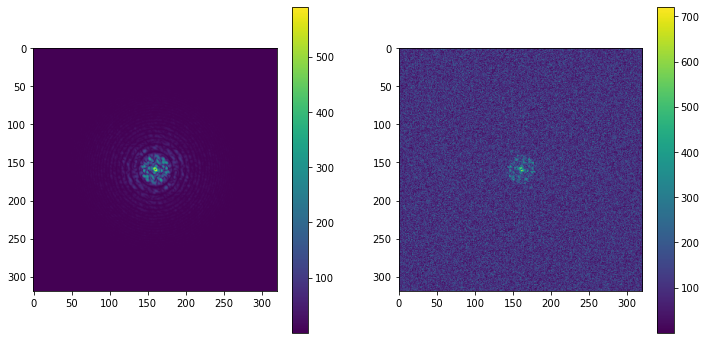

In [51]:
idx = 14
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(np.fft.fftshift(np.abs(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(np.abs(imgs_f_noisy[idx].reshape([nx,nx])))); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6


### 3. Relion + Cryodrgn - IGNORE THIS

In [ ]:
mrcs_dir_clean = "mixed_clean"
mrcs_dir_noisy = "mixed_noisy"
imgs_filename = "particles"

shifts1 = np.zeros([N1,2])
shifts2 = shifts1

ctf_params1 = np.tile(ctf_params_common, (N1,1))
ctf_params2 = ctf_params1

In [ ]:
# Take projections in Fourier
#imgs_f1 = slice_func_array(vol1, angles1, shifts1, ctf_params1)
#imgs_f2 = slice_func_array(vol2, angles2, shifts2, ctf_params2)

In [ ]:
# Take projections in Fourier - in batches so they fit on the GPU
N_batch = 10

imgs_f12 = []
for vol, angles, shifts, ctf_params in [(vol1, angles1, shifts1, ctf_params1), (vol2, angles2, shifts2, ctf_params2)]:

    angles_batch = np.array(np.array_split(angles, N_batch))
    shifts_batch = np.array(np.array_split(shifts, N_batch))
    ctf_params_batch = np.array(np.array_split(ctf_params, N_batch))

    imgs_f_batch = [] #np.array(np.array_split(imgs_f, N_batch))


    for bi in np.arange(N_batch):
        imgs_f = slice_func_array(vol, angles_batch[bi], shifts_batch[bi], ctf_params_batch[bi])

        # Move to CPU
        imgs_f_batch.append(np.array(imgs_f))


    imgs_f = np.concatenate(imgs_f_batch, axis=0)
    
    imgs_f12.append(imgs_f)
    
imgs_f1 = imgs_f12[0]
imgs_f2 = imgs_f12[1]

In [ ]:
angles = np.concatenate([angles1, angles2], axis=0)
imgs_f = np.concatenate([imgs_f1, imgs_f2], axis=0)  
shifts = np.concatenate([shifts1, shifts2], axis=0)
ctf_params = np.concatenate([ctf_params1, ctf_params2], axis=0)

N = angles.shape[0]

z = np.concatenate([np.zeros([int(N/2),1]), np.ones([int(N/2),1])], axis=0)

In [ ]:
idx = np.random.permutation(N)

imgs_f = imgs_f[idx]
angles = angles[idx]
z = z[idx]

In [ ]:
#plt.plot(z)

In [ ]:
imgs, imgs_f, imgs_noisy, imgs_f_noisy = prepare_imgs(imgs_f, angles, shifts, ctf_params, sigma_noise)

In [ ]:
_, _ = compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy)

In [ ]:
df_clean = write_star_and_mrcs(out_dir, mrcs_dir_clean, imgs_filename, imgs)
df_noisy = write_star_and_mrcs(out_dir, mrcs_dir_noisy, imgs_filename, imgs_noisy)

In [ ]:
# Also print the z to file
for mrcs_dir in [mrcs_dir_clean, mrcs_dir_noisy]:
    file = open(f"{out_dir}/{mrcs_dir}/z.pkl", 'wb')
    pickle.dump(z, file)
    file.close()



In [ ]:
idx = 11
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow((np.abs(imgs[idx].reshape([128,128])))); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow((np.abs(imgs_noisy[idx].reshape([128,128])))); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [ ]:
idx = 14
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(np.fft.fftshift(np.abs(imgs_f[idx].reshape([128,128])))); plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(np.abs(imgs_f_noisy[idx].reshape([128,128])))); plt.colorbar()

plt.rcParams["figure.figsize"]=6,6